In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC 

# Загрузка данных

In [2]:
class Loader:
    def __init__(self, data):
        if data == 'mashroom':
            self.data = pd.read_csv('2. Mushroom_dataset', delimiter = ",", names=['class-label','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'])
            self.data = self.data.drop(['veil-type'], axis=1)

            le = preprocessing.LabelEncoder()
            for col in self.data.columns:
                self.data[col] = le.fit_transform(self.data[col])

            X = self.data.drop(['class-label'], axis=1)
            y = self.data['class-label']
        else:
            self.data = pd.read_csv(r"C:\Users\makso\Desktop\АМО\linear\iris.csv")[0:100]
            le = preprocessing.LabelEncoder()
            self.data['species'] = le.fit_transform(self.data['species'])

            X = self.data.drop(['species'], axis=1)
            y = self.data['species']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.25, random_state=24)

In [20]:
loader = Loader('iris')
X_train, X_test, y_train, y_test = loader.X_train, loader.X_test, loader.y_train, loader.y_test

# Метрики

In [4]:
#accuracy

def accuracy(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return (len(TP) + len(TN)) / len(compare_df)

#precession

def precession(y_test, y_pred):
    compare_df = pd.DataFrame({'y': (y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return len(TP) / (len(TP) + len(FP))

#recall

def recall(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    return len(TP) / (len(TP) + len(FN))
                                    
#f1

def f1(y_test, y_pred):
    compare_df = pd.DataFrame({'y': list(y_test), 'y_pred': y_pred})
    
    TP = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 1)]
    FP = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 1)]
    FN = compare_df.loc[(compare_df['y'] == 1) & (compare_df['y_pred'] == 0)]
    TN = compare_df.loc[(compare_df['y'] == 0) & (compare_df['y_pred'] == 0)]
    
    precession_ = precession(y_test, y_pred)
    recall_ = recall(y_test, y_pred)
    return 2 * precession_ * recall_ / (recall_+ precession_)

# SVM

In [5]:
class SVM:
    def __init__(self, kernel, C=1, gamma=1, degree=3):
        self.C = C
        self.alpha = None
        self.b = None
        self.gamma = gamma
        self.degree = degree
        self.support_vectors = None
        self.support_vector_labels = None
        self.kernel = kernel
        self.weights = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape

        y = np.where(y <= 0, -1, 1)

        # Определение функции для минимизации
        def objective(alpha):
            if self.kernel == 'polinomial':
                K = np.array([[self.polynomial_kernel(X[i], X[j]) for j in range(n_samples)] for i in range(n_samples)])
            elif self.kernel == 'rbf':
                K = np.array([[self.rbf_kernel(X[i], X[j]) for j in range(n_samples)] for i in range(n_samples)])
            else:
                K = np.dot(X, X.T)
            return 0.5 * np.sum(alpha[:, None] * alpha[None, :] * y[:, None] * y[None, :] * K) - np.sum(alpha)

        # Границы для альфа
        bounds = [(0, self.C) for _ in range(n_samples)]
        # Начальное значение альфа
        initial_alpha = np.zeros(n_samples)

        # Оптимизация двойственной задачи
        constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)}
        result = minimize(objective, initial_alpha, bounds=bounds, constraints=constraints)

        self.alpha = result.x

        # Индексы векторов поддержки
        support_indices = self.alpha > 1e-5
        self.support_vectors = X[support_indices]
        self.support_vector_labels = y[support_indices]
        self.alpha = self.alpha[support_indices]

        # Вычисление b
        self.b = np.mean(self.support_vector_labels - np.dot(X[support_indices], self._get_weights()))

    def rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    def polynomial_kernel(self, x1, x2):
        return (np.dot(x1, x2) + 1) ** self.degree

    def _get_weights(self):
        return np.sum(self.alpha[:, None] * self.support_vector_labels[:, None] * self.support_vectors, axis=0)

    def predict(self, X):
        self.weights = self._get_weights()
        return np.sign(np.dot(X, self.weights) + self.b)

## Линейное ядро

In [6]:
%%time
# вручную
svm = SVM(kernel='linear')
svm.fit(X_train, y_train)

pred = list(np.where(svm.predict(X_test) < 0, 0, 1))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 46.9 ms
Wall time: 69 ms


In [7]:
%%time
# библиотека
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

pred = list(svm.predict(X_test))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 0 ns
Wall time: 114 ms


## RBF

In [8]:
%%time
# вручную
svm = SVM(kernel='rbf')
svm.fit(X_train, y_train)

pred = list(np.where(svm.predict(X_test) < 0, 0, 1))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 46.2 s
Wall time: 1min 17s


In [9]:
%%time
# библиотека
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

pred = list(svm.predict(X_test))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 0 ns
Wall time: 32.8 ms


## Poplynomial

In [10]:
%%time
# вручную
svm = SVM(kernel='polynimial')
svm.fit(X_train, y_train)

pred = list(np.where(svm.predict(X_test) < 0, 0, 1))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 78.1 ms
Wall time: 165 ms


In [11]:
%%time
# библиотека
svm = SVC(kernel='poly')
svm.fit(X_train, y_train)

pred = list(svm.predict(X_test))

print(f'Accuracy: {accuracy(y_test, pred)}')
print(f'Precession: {precession(y_test, pred)}')
print(f'Recall: {recall(y_test, pred)}')
print(f'F1: {f1(y_test, pred)}')

Accuracy: 1.0
Precession: 1.0
Recall: 1.0
F1: 1.0
CPU times: total: 15.6 ms
Wall time: 33.7 ms


# Visualisation

In [33]:
class Visual:
    def __init__(self, X, y, svm):
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)

        plt.figure(figsize=(10, 6))
        plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], color='blue', label='1', alpha=0.7)
        plt.scatter(X_reduced[y == -1, 0], X_reduced[y == -1, 1], color='red', label='-1', alpha=0.7)

        X_support_reduced = pca.transform(svm.support_vectors)
        plt.scatter(X_support_reduced[:, 0], X_support_reduced[:, 1], facecolors='none', edgecolors='k', s=100, label='Опорные вектора')

        point = pca.transform(svm.weights[None, :])
#         x = float(point[0][0])
#         y = float(point[0][1])
#         b = svm.b
#         k = (y - b) / x
        x = [-4, 2]
        y = [_ * point[0][1] + point[0][0] for _ in x]
        plt.plot(x, y)

        plt.title('SVM')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

In [34]:
svm = SVM(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_test_visual = np.where(np.array(y_test) == 0, -1, 1)

C:\Users\makso\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\makso\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(1, 4)


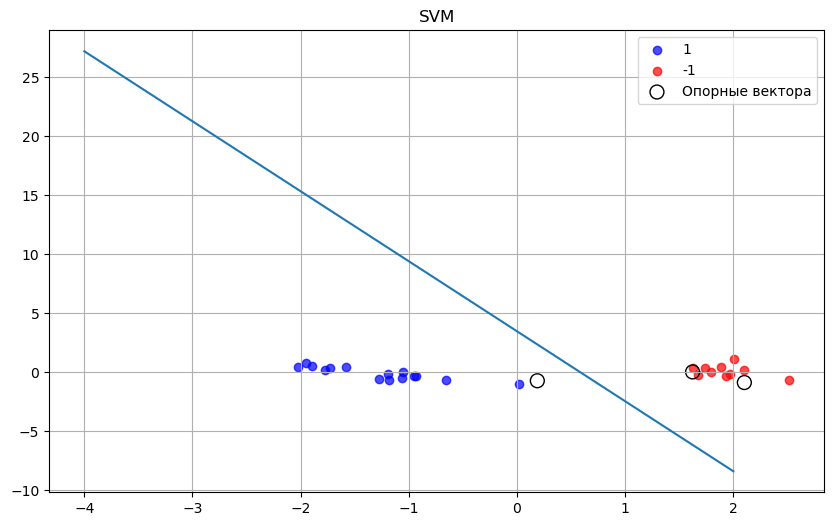

In [35]:
Visual(X_test, y_test_visual, svm)